## Function Definitions

In [1]:
import geopandas as gpd
import pickle
import numpy as np
import glob
import os
import sys
from copy import deepcopy
import scipy.stats
import pandas as pd

from climada.util import coordinates as u_coords

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def load_dict(path_dict):
    # load any dict saved as pkl
    with open(path_dict, 'rb') as stats_dict:
         stats_dict = pickle.load(stats_dict)
    return stats_dict

def save_dict(dict_var, save_path):
    # save any dict as pkl
    with open(save_path, 'wb') as f:
        pickle.dump(dict_var, f)

In [3]:
def service_dict2():
    """service supply variables from raw output 
    to basic service names"""
    return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile /n communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}

In [4]:
def load_gdf_dict(path_cntry_folder, haz_type, valid_events):
    # get all result dataframes filepaths
    if haz_type == 'TC':
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results*') 
                              if not 'DFO' in file]
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if path.split('_')[-1] in valid_events]
        
    elif haz_type == 'FL':
        paths_result_files = glob.glob(path_cntry_folder + 'cascade_results_DFO*')
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if 'DFO_'+ path.split('_')[-1] in valid_events]
    elif haz_type == 'RF':
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results*') 
                              if not 'DFO' in file]
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if path.split('_')[-1] in valid_events]
    # move old files for good
    paths_invalid_resfiles = set(paths_result_files).difference(paths_valid_resfiles)
    for path in paths_invalid_resfiles:
        new_path = path_cntry_folder+f"old/cascade_results_{path.split('_')[-1]}"
        os.rename(path, new_path)
        
    # read in all result gdfs
    gdf_list= []
    name_list = []
    for file_path in paths_valid_resfiles:
        event_name = file_path.split('_')[-1] if haz_type in ['TC', 'RF'] else 'DFO_'+ file_path.split('_')[-1]
        name_list.append(event_name)
        gdf_list.append(gpd.read_feather(file_path)) 
    # make dict
    return dict(zip(name_list, gdf_list))


## Creating Average Impact Cascade Factors

### Cascade Factor A (all service losses : all directly affected)

In [ ]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps = load_dict(path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}
    save_dict(total_imps_rela, path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_{iso3}_{haz_type}_{state}.pkl')
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}
    save_dict(total_imps_rela, path_cntry_folder+f'{state}/total_service_disruptions_rela_{iso3}_{state}_{haz_type}.pkl')


### Cascade Factor B (spatial cascade - all service losses : service losses of dir. affected)

In [ ]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relb={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relb={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')    
                                              

### Cascade Factor C (number of service losses : number of service access in dir. affected area)

In [135]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'    
    total_imps_relc={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relc={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')
                                              

In [24]:
gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))

## Creating event-wise impact cascade factors

In [ ]:
# only for "Factor C"
perevent_factor_c={}

haz_type = 'TC'
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ',  'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    if not os.path.isfile(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.pkl'):
    # define necessary paths
        path_event_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
        dict_event_stats = load_dict(path_event_stats)
        dict_gdfs = load_gdf_dict(path_cntry_folder, haz_type, valid_events=list(dict_event_stats.keys()))

        perevent_factor_c[iso3] = {}

        for event_id, imp_gdf in dict_gdfs.items():
            perevent_factor_c[iso3][event_id] = {}
            imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
            for variable, service in service_dict2().items():
                lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
                # has or had service, in directly affected area
                had_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]!=0)]['counts'].sum()
                perevent_factor_c[iso3][event_id][service] = np.round(np.abs(lost_service/had_service_affected),2)
                if lost_service==0:
                    perevent_factor_c[iso3][event_id][service] = 0
            perevent_factor_c[iso3][event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()

        # convert to dataframe    
        df_factor_c = pd.DataFrame.from_dict(perevent_factor_c[iso3])
        # get rid of all-0 events
        drop_cols = df_factor_c.columns[[np.where(df_factor_c.apply(lambda col: np.all(col==0)))[0]]].values
        for drop_col in drop_cols:
            df_factor_c.pop(drop_col)
        df_factor_c['median'] = df_factor_c.apply(lambda row: np.median(row.values), axis=1)    
        perevent_factor_c[iso3] = df_factor_c
        df_factor_c.to_csv(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.pkl')
    else:
        perevent_factor_c[iso3] = pd.read_csv(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.pkl',
                                             index_col=0)
    print(iso3)
    print(perevent_factor_c[iso3])

ATG
                          1995241N11333  1999291N10309  2017242N16333  \
electricity                        1.00           0.36           1.00   
mobile /n communications           1.00           0.11           1.00   
healthcare                         1.00           0.00           1.00   
education                          1.00           0.33           1.00   
mobility                           0.89           0.01           0.88   
population                         1.00           1.00           1.00   

                          1989254N13340  1996187N10326  1995256N12309  \
electricity                    1.010000       0.000000            inf   
mobile /n communications       1.010000       0.000000            0.0   
healthcare                     1.000000       0.000000            0.0   
education                      1.010000       0.000000            inf   
mobility                       0.890000       0.000000            0.0   
population                     0.994314       

In [ ]:
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    # define necessary paths
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    path_event_stats = path_cntry_folder+f'{state}/service_stats_{haz_type}_{iso3}_{state}.pkl'
    dict_event_stats = load_dict(path_event_stats)
    dict_gdfs = load_gdf_dict(path_cntry_folder+f'{state}/', haz_type, valid_events=list(dict_event_stats.keys()))
    
    perevent_factor_c[f'{iso3} {state}'] = {}
    
    for event_id, imp_gdf in dict_gdfs.items():
        perevent_factor_c[f'{iso3} {state}'][event_id] = {}
        imp_gdf = imp_gdf[imp_gdf.ci_type=='people']
        for variable, service in service_dict2().items():
            lost_service = imp_gdf[imp_gdf[variable]<0]['counts'].sum()
            # has or had service, in directly affected area
            had_service_affected = imp_gdf[(imp_gdf['imp_dir']>0) & (imp_gdf[variable]!=0)]['counts'].sum()
            perevent_factor_c[f'{iso3} {state}'][event_id][service] = np.round(np.abs(lost_service/had_service_affected),2)
            if lost_service==0:
                perevent_factor_c[f'{iso3} {state}'][event_id][service] = 0
        perevent_factor_c[f'{iso3} {state}'][event_id]['population'] = imp_gdf[(imp_gdf['imp_dir']>0)]['counts'].sum()/imp_gdf['counts'].sum()
    
    # convert to dataframe    
    df_factor_c = pd.DataFrame.from_dict(perevent_factor_c[f'{iso3} {state}'])
    # get rid of all-0 events
    drop_cols = df_factor_c.columns[[np.where(df_factor_c.apply(lambda col: np.all(col==0)))[0]]].values
    for drop_col in drop_cols:
        df_factor_c.pop(drop_col)
    df_factor_c['median'] = df_factor_c.apply(lambda row: np.median(row.values), axis=1)    
    perevent_factor_c[f'{iso3} {state}'] = df_factor_c
    

In [ ]:
# save entire dict
save_dict(perevent_factor_c, f'/cluster/work/climate/evelynm/nw_outputs/factor_c_eventwise_{haztype}_allcntrs.pkl')

### Loading Impact Cascade Factors

In [4]:
# Comparison 1: Cascading factors
haz_type = 'TC'
total_imps_rela={}
total_imps_relb={}
total_imps_relc={}
perevent_factor_c={}

for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ',  'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')
    total_imps_relb[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
    total_imps_relc[iso3] = load_dict( path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_rela_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relb[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relc[f'{iso3} {state}'] = load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')

perevent_factor_c = load_dict( f'/cluster/work/climate/evelynm/nw_outputs/factor_c_eventwise_{haztype}_allcntrs.pkl')

In [5]:
#print(total_imps_relb)
#print(total_imps_rela)
#print(total_imps_relc)


In [107]:
iso3 = 'HTI'
df_factor_c = perevent_factor_c[iso3]
df_factor_c.T.plot(kind='box')

<AxesSubplot: xlabel='population', ylabel='mobility'>

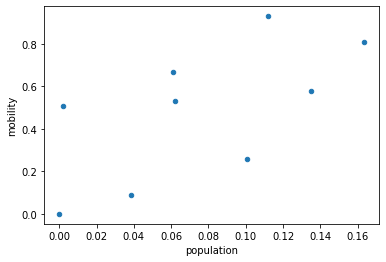

In [53]:
df_factor_c.T.plot(x='population', y='mobility', kind='scatter')

<AxesSubplot: xlabel='population', ylabel='electricity'>

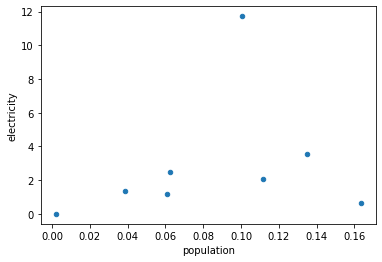

In [54]:
df_factor_c.T.plot(x='population', y='electricity', kind='scatter')

<AxesSubplot: xlabel='population', ylabel='healthcare'>

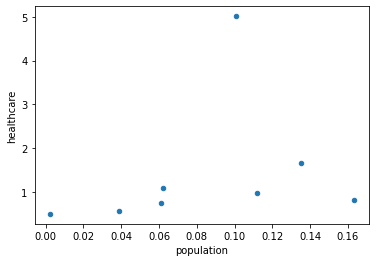

In [55]:
df_factor_c.T.plot(x='population', y='healthcare', kind='scatter')

<AxesSubplot: xlabel='population', ylabel='education'>

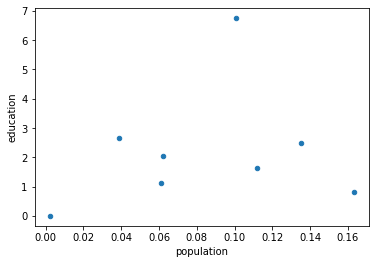

In [56]:
df_factor_c.T.plot(x='population', y='education', kind='scatter')

## Overview Plots

In [5]:
def plot_relative_impacts_bars(imp_dict_relb_all, imp_dict_rela_all, imp_dict_relc_all, save_path=None):
    """all in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(int(len(imp_dict_relb_all.keys())/3), 9, figsize=(15, 0.8*len(imp_dict_relb_all.keys())),
                          sharex=True, sharey=True)
    
    width = 0.8
    x = np.arange(5)
    axes = axes.flatten()
            
    i=0
    for out_a, out_b, out_c in zip( imp_dict_rela_all.items(), imp_dict_relb_all.items(), imp_dict_relc_all.items()):
        
        ax1=axes[i]
        ax2=axes[i+1]
        ax3=axes[i+2]
        
        iso3 = out_a[0]
        imp_dict_rela = out_a[1]
        imp_dict_relb = out_b[1]
        imp_dict_relc = out_c[1]
        
        relb_base = imp_dict_relb.pop('people')
        rela_base = imp_dict_rela.pop('people')
        relc_base = imp_dict_relc.pop('people')
        relb_vals = np.round(np.array(list(imp_dict_relb.values())),2)
        rela_vals = np.round(np.array(list(imp_dict_rela.values())),2)
        relc_vals = np.round(np.array(list(imp_dict_relc.values())),2)
        
        labels = imp_dict_relb.keys()

        rects1 = ax1.bar(x, rela_vals, width, color='red', label='rel. to pop. with service loss in dir. affected area')
        ax1.title.set_text(f'{iso3}')
        ax1.set_xticks(x, labels, rotation=90)
        ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        #ax1.legend()
        ax1.bar_label(rects1, padding=3)

        rects2 = ax2.bar(x, relb_vals, width, color='blue', label='rel. to directly affected pop.')
        ax2.set_xticks(x, labels, rotation=90)
        ax2.title.set_text(f'{iso3}')
        ax2.plot([0.-width/2, 4+width/2], [rela_base, rela_base], "k--", linewidth=2)
        #ax2.legend()
        ax2.bar_label(rects2, padding=3)
        
        rects3 = ax3.bar(x, relc_vals, width, color='green', label='rel. to pop. with initial services in dir. affected ar')
        ax3.set_xticks(x, labels, rotation=90)
        ax3.title.set_text(f'{iso3}')
        ax3.plot([0.-width/2, 4+width/2], [relc_base, relc_base], "k--", linewidth=2)
        #ax2.legend()
        ax3.bar_label(rects3, padding=3)
        i+=3
        
    legend_elements = [Patch(facecolor='r', edgecolor='r',
                         label='Factor A'),
                      Patch(facecolor='b', edgecolor='b',
                         label='Factor B'),
                      Patch(facecolor='g', edgecolor='g',
                         label='Factor C')]
    f.legend(handles=legend_elements, frameon=False, fontsize=16,
            bbox_to_anchor=(0.7, 0),
            ncol=len(labels))    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.tight_layout()
    plt.show()

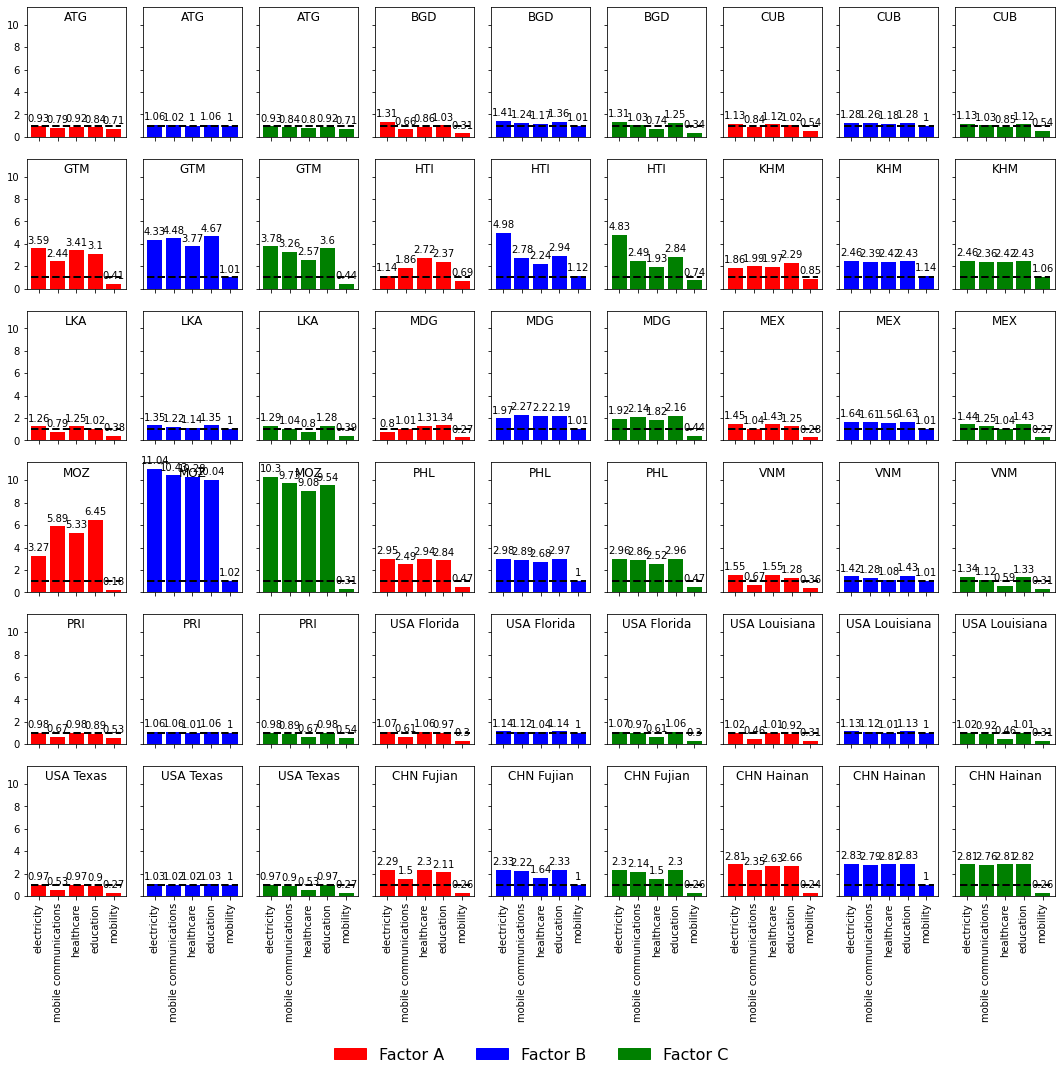

In [147]:
plot_relative_impacts_bars(deepcopy(total_imps_relb), deepcopy(total_imps_rela), deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_both')

In [6]:

def plot_relative_impacts_bars_2(imp_dict_relb_all, save_path=None):
    """both in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(3,6, figsize=(15, 10),
                          sharex=True, sharey=True)
    
    width = 0.8
    x = np.arange(5)
    axes = axes.flatten()
    my_cmap = plt.get_cmap("Set3") #
    i=0
    for iso3, imp_dict_relb in imp_dict_relb_all.items():
        
        ax1=axes[i] 
        divider = make_axes_locatable(ax1)
        ax2 = divider.new_vertical(size="40%", pad=0.1)
        f.add_axes(ax2)
        
        relb_base = imp_dict_relb.pop('people')
        relb_vals = np.round(np.array(list(imp_dict_relb.values())),2)
        labels = imp_dict_relb.keys()
        
        rects1 = ax1.bar(x, relb_vals, width, color=my_cmap.colors, label='rel. to pop. with service access in base state')
        if (i%6)==0:
            ax1.set_ylabel('Resilience Cascade Factor')
        ax1.set_xticks([])
        ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        ax1.bar_label(rects1, padding=3)
        ax1.set_ylim(0, 5)
        ax1.spines['top'].set_visible(False)
        rects1 = ax2.bar(x, relb_vals, width, color=my_cmap.colors, label='')
        ax2.set_title(f'{iso3}',y=1.0, pad=-14) #title.set_text(
        #plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
        #plt.rcParams['axes.titlepad'] = -14  # pad is in points...
        ax2.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        ax2.set_ylim(9, 11.5)
        if (i%6)!=0:
            ax2.yaxis.set_ticklabels([])
        ax2.bar_label(rects1, padding=3)
        ax2.tick_params(bottom=False, labelbottom=False)
        ax2.spines['bottom'].set_visible(False)
        
        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
        kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
        ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        i+=1
        
    #f.suptitle( f"Average relative service disruptions from {haz_type}, all countries , {year_range}",  fontsize=16)
    #f.tight_layout()
    remainder=(len(imp_dict_relb_all.keys())%3)*-1
    
    legend_elements = [Patch(facecolor=my_cmap.colors[i], edgecolor=my_cmap.colors[i],
                         label=list(labels)[i]) for i in range(len(labels))]
    f.legend(handles=legend_elements, frameon=False, fontsize=16,
            bbox_to_anchor=(0.9, 0),
            ncol=len(labels))

    if remainder < 0:
        for ax in axes[remainder:]:
            ax.remove()
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_cascfactor_boxplots(perevent_factor_c, save_path=None):
    """both in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(3,6, figsize=(15, 10),
                          sharex=True, sharey=True)
    
    width = 0.8
    x = np.arange(5)
    axes = axes.flatten()
    my_cmap = plt.get_cmap("Set3") #
    i=0
    for iso3, imp_dict_relb in imp_dict_relb_all.items():
        
        ax1=axes[i] 
        divider = make_axes_locatable(ax1)
        ax2 = divider.new_vertical(size="40%", pad=0.1)
        f.add_axes(ax2)
        
        relb_base = perevent_factor_c.drop('people')
        relb_vals = np.round(np.array(list(imp_dict_relb.values())),2)
        labels = imp_dict_relb.keys()
        
        rects1 = ax1.bar(x, relb_vals, width, color=my_cmap.colors)
        if (i%6)==0:
            ax1.set_ylabel('Resilience Cascade Factor')
        ax1.set_xticks([])
        ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        ax1.bar_label(rects1, padding=3)
        ax1.set_ylim(0, 5)
        ax1.spines['top'].set_visible(False)
        rects1 = ax2.bar(x, relb_vals, width, color=my_cmap.colors, label='')
        ax2.set_title(f'{iso3}',y=1.0, pad=-14) #title.set_text(
        #plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
        #plt.rcParams['axes.titlepad'] = -14  # pad is in points...
        ax2.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
        ax2.set_ylim(9, 11.5)
        if (i%6)!=0:
            ax2.yaxis.set_ticklabels([])
        ax2.bar_label(rects1, padding=3)
        ax2.tick_params(bottom=False, labelbottom=False)
        ax2.spines['bottom'].set_visible(False)
        
        d = .015  # how big to make the diagonal lines in axes coordinates
        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
        ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
        ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
        kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
        ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
        ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
        i+=1
        
    #f.suptitle( f"Average relative service disruptions from {haz_type}, all countries , {year_range}",  fontsize=16)
    #f.tight_layout()
    remainder=(len(imp_dict_relb_all.keys())%3)*-1
    
    legend_elements = [Patch(facecolor=my_cmap.colors[i], edgecolor=my_cmap.colors[i],
                         label=list(labels)[i]) for i in range(len(labels))]
    f.legend(handles=legend_elements, frameon=False, fontsize=16,
            bbox_to_anchor=(0.9, 0),
            ncol=len(labels))

    if remainder < 0:
        for ax in axes[remainder:]:
            ax.remove()
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.tight_layout()
    plt.show()

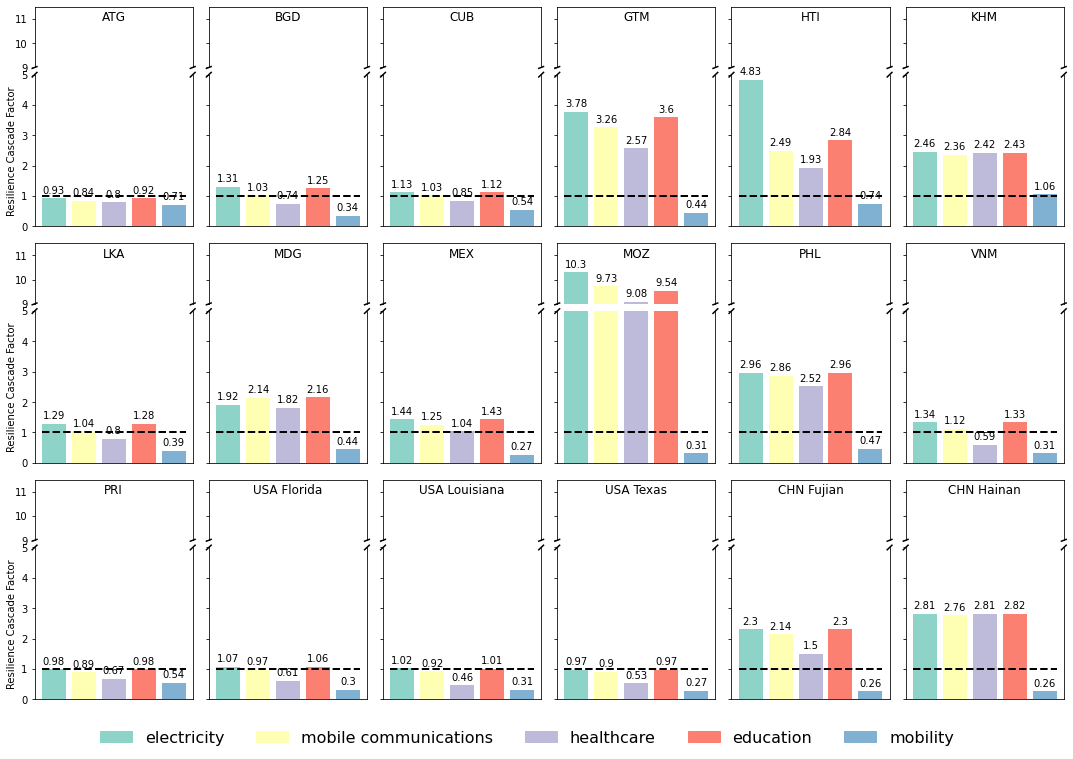

In [126]:
plot_relative_impacts_bars_2(deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_c')


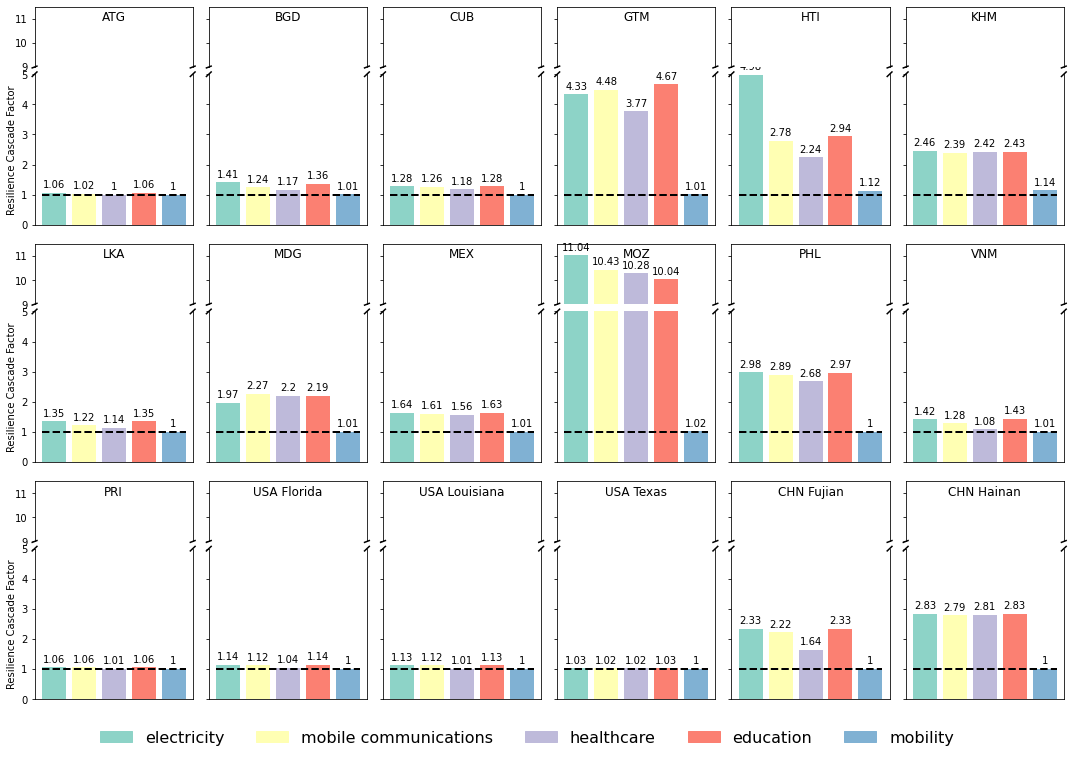

In [127]:
plot_relative_impacts_bars_2(deepcopy(total_imps_relb), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_b')


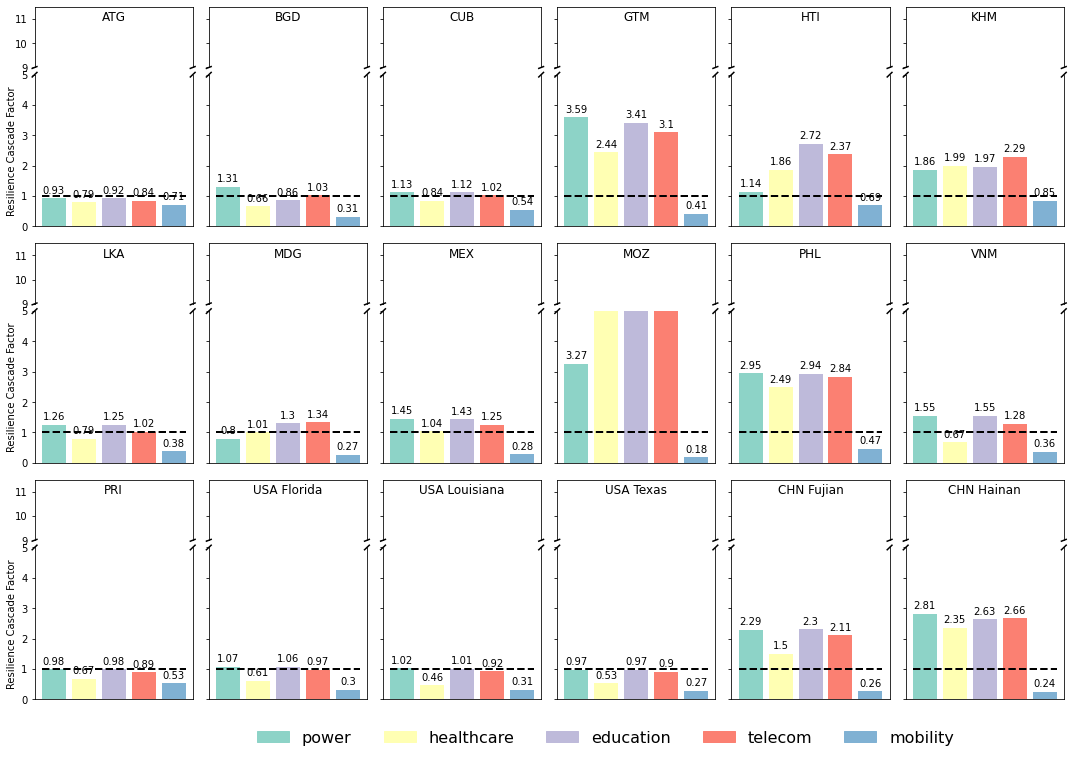

In [128]:
plot_relative_impacts_bars_2(deepcopy(total_imps_rela), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_a')


In [7]:
def inc_class_dict():
    return {'ATG': 1,
 'BGD': 4,
 'CUB': 2,
 'GTM': 2,
 'HTI': 4,
 'KHM': 3,
 'LKA': 3,
 'MDG': 4,
 'MEX': 2,
 'MOZ': 4,
 'PHL': 3,
 'VNM': 3,
 'PRI': 1,
 'USA Florida': 1,
 'USA Louisiana': 1,
 'USA Texas': 1,
 'CHN Fujian': 2,
 'CHN Hainan': 2}

In [8]:
def pop_density_dict():
    return {'ATG': 222,
 'BGD': 1265,
 'CUB': 110,
 'GTM': 167,
 'HTI': 413,
 'KHM': 95,
 'LKA': 354,
 'MDG': 47,
 'MEX': 66,
 'MOZ': 39,
 'PHL': 367,
 'VNM': 313,
 'PRI': 360,
 'USA Florida': 136,
 'USA Louisiana': 41,
 'USA Texas': 43,
 'CHN Fujian': 350,
 'CHN Hainan': 276}

In [29]:
dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))

{'electricity': [],
 'mobile communications': [],
 'healthcare': [],
 'education': [],
 'mobility': []}

In [31]:
def scatter_cascade_ranking(imp_dict_relb_all, ref_dict, label, annotate=False, save_path=None):
    summary_dict = {}   
    for iso3, imp_dict in imp_dict_relb_all.items():
        imp_dict.pop('people')
        summary_dict[iso3] = np.array(list(imp_dict.values())).sum()/5
        
    fig, ax = plt.subplots()
    x = [ref_dict[iso3] for iso3 in summary_dict.keys()]
    y = [value for value in summary_dict.values()]
    z = [iso3 for iso3 in imp_dict_relb_all.keys()]
    
    ax.scatter(x,y)
    if annotate:    
        for i, txt in enumerate(z):
            ax.annotate(txt, (x[i]+0.2, y[i]+0.2))
    
    #plt.xticks(np.arange(5.5))
    plt.xlabel(label)
    plt.ylabel('average cascade factor')
    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()
                

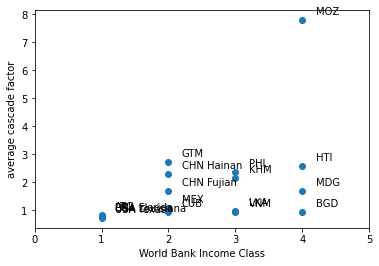

In [30]:
scatter_cascade_ranking(deepcopy(total_imps_relc), inc_class_dict(), annotate=True, label='World Bank Income Class')

In [ ]:
scatter_cascade_ranking_perservice(imp_dict_relb_all, ref_dict, label, save_path=None)

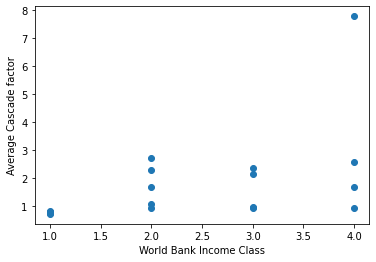

In [145]:
scatter_cascade_ranking(deepcopy(total_imps_relc), inc_class_dict(), label='World Bank Income Class')

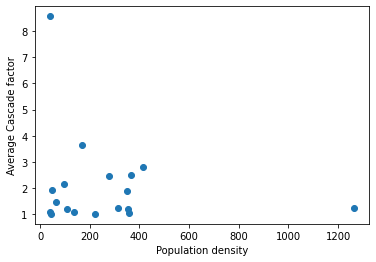

In [15]:
scatter_cascade_ranking(deepcopy(total_imps_relb), pop_density_dict(), label='Population density')

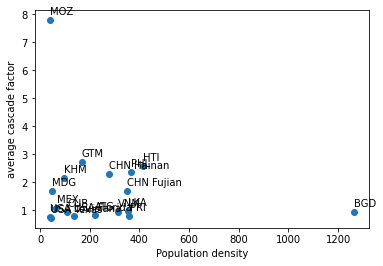

In [32]:
scatter_cascade_ranking(deepcopy(total_imps_relc), pop_density_dict(), annotate=True, label='Population density')

In [10]:
import seaborn as sns
def scatter_cascade_ranking_perservice(imp_dict_relb_all, save_path=None):
    
    f, ax = plt.subplots(1,1, figsize=(10, 10),
                          sharex=True, sharey=True)
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    summary_df = pd.DataFrame.from_dict(summary_dict)
    sns.catplot(summary_df)
    #plt.xticks(np.arange(5))
    #plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

In [12]:
import seaborn as sns
def scatter_cascade_ranking_perservice(imp_dict_relb_all, save_path=None):
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    summary_df = pd.DataFrame.from_dict(summary_dict)
    print(summary_df)
    sns.catplot(summary_df)

In [147]:
col_list = ['casc_factor_b','casc_factor_c', 'service', 'iso3']
cascade_factors_df = pd.DataFrame(columns=col_list)
for items_b, items_c in zip(total_imps_relb.items(), total_imps_relc.items()):
    cntry_df = pd.DataFrame(columns=col_list)
    cntry_df['casc_factor_b'] = list(items_b[1].values())[:-1]
    cntry_df['casc_factor_c'] = list(items_c[1].values())[:-1]
    cntry_df['service'] = list(cntry_dict.keys())[:-1]
    cntry_df['iso3'] = items_b[0]
    cascade_factors_df = cascade_factors_df.append(cntry_df, ignore_index=True)

In [148]:
cascade_factors_df['WB_inc_class'] = cascade_factors_df.apply(lambda row: inc_class_dict()[row.iso3], axis=1)

In [149]:
cascade_factors_df['pop_density'] = cascade_factors_df.apply(lambda row: pop_density_dict()[row.iso3], axis=1)

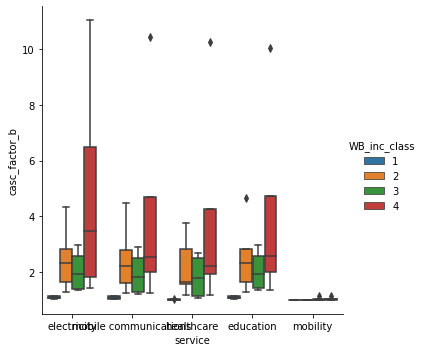

In [150]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", kind='box', hue="WB_inc_class")

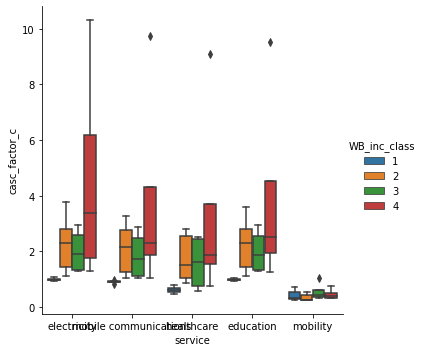

In [151]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", kind='box', hue="WB_inc_class")

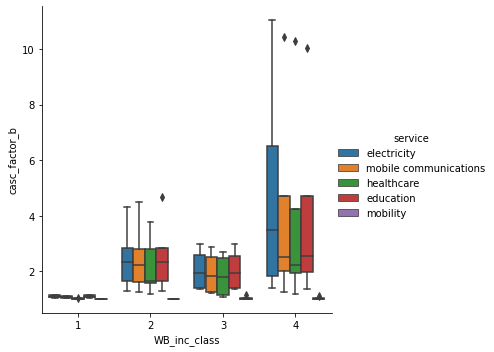

In [152]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_b", kind='box', hue="service")

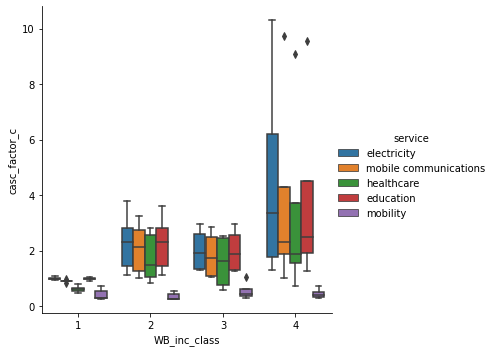

In [153]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_c", kind='box', hue="service")

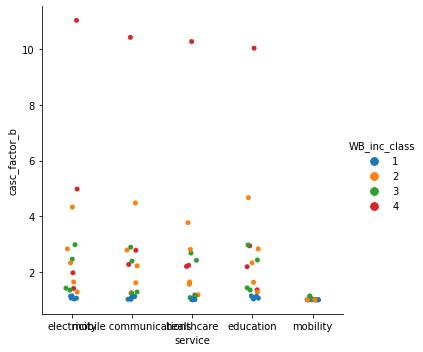

In [154]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", hue="WB_inc_class")

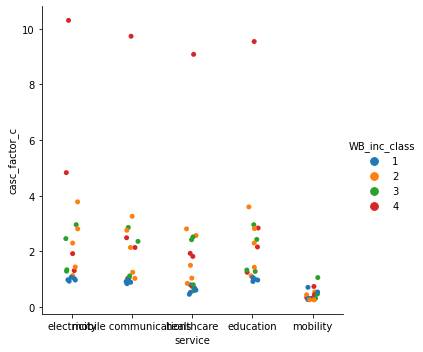

In [155]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", hue="WB_inc_class")

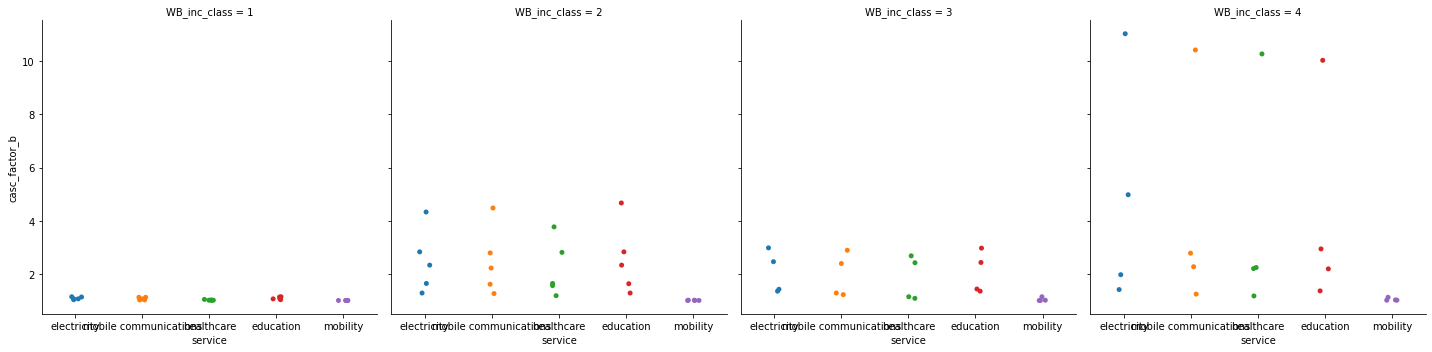

In [159]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", col="WB_inc_class")

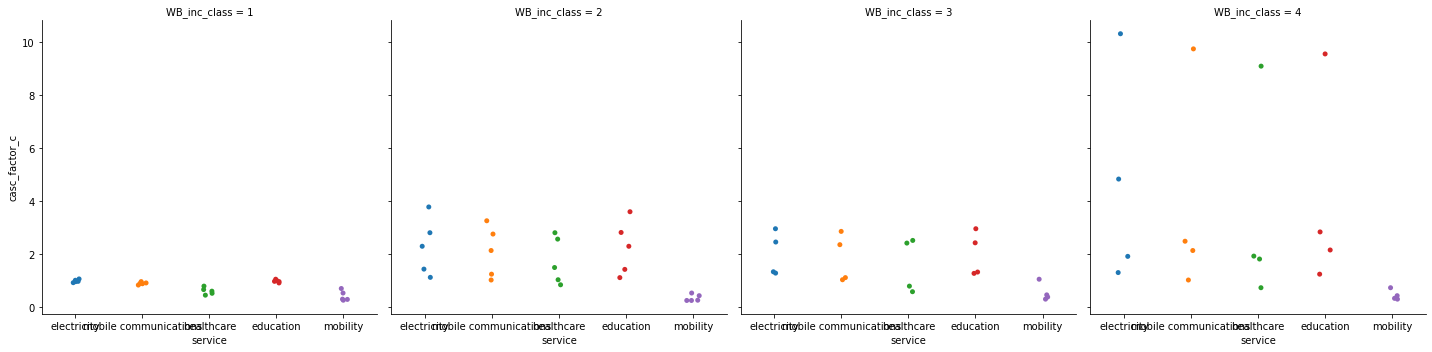

In [158]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", col="WB_inc_class")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_b'>

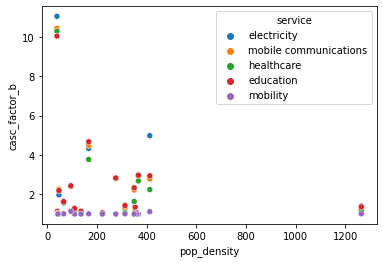

In [156]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_b", hue="service")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_c'>

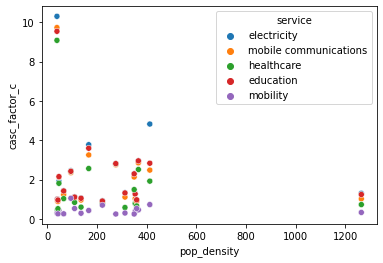

In [157]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_c", hue="service")

In [34]:
def scatter_cascade_ranking_perservice(imp_dict_relb_all, ref_dict, label, save_path=None):
    
    f, axes = plt.subplots(3,2, figsize=(15, 10),
                          sharex=True, sharey=True)
    axes = axes.flatten()
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    for ax in axes:
        ax.scatter([ref_dict[iso3] for iso3 in summary_dict.keys()], summary_dict.values())
    #plt.xticks(np.arange(5))
    plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

In [35]:
def calc_infra_density(iso3, state=None):
    path_nw_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    infra_density_dict = {}
    if state:
        path_nw_folder+=f'{state}/'
    df_edges = gpd.read_feather(path_nw_folder+'cis_nw_edges')
    df_nodes = gpd.read_feather(path_nw_folder+'cis_nw_nodes')
    pop_count = df_nodes[df_nodes.ci_type=='people'].counts.sum()
    
    for ci_type in ['health', 'education', 'celltower', 'power_plant']:
        infra_density_dict[ci_type] = len(df_nodes[df_nodes.ci_type==ci_type])/pop_count
    for ci_type in ['power_line', 'road']:
        infra_density_dict[ci_type] = df_edges[df_edges.ci_type=='power_line']['distance'].sum()/pop_count
    return infra_density_dict

In [37]:
iso3='HTI'
calc_infra_density(iso3, state=None)

{'health': 0.00015995519808016968,
 'education': 0.0006516968163080695,
 'celltower': 2.8483901282257595e-05,
 'power_plant': 3.711257496059622e-07,
 'power_line': 0.37050324218873254,
 'road': 0.37050324218873254}

In [38]:
infra_density_dict = {}
for key in total_imps_relc.keys():
    try:
        iso3, state = key.split(' ')
    except ValueError:
        iso3 = key
        state = None
    infra_density_dict[key] = calc_infra_density(iso3, state)

pd.DataFrame.from_dict(infra_density_dict)

,ATG,BGD,CUB,GTM,HTI,KHM,LKA,MDG,MEX,MOZ,PHL,VNM,PRI,USA Florida,USA Louisiana,USA Texas,CHN Fujian,CHN Hainan
health,0.000181,1.433060e-05,0.000202,0.000045,1.599552e-04,3.909115e-05,0.000083,4.749156e-05,0.000053,3.762253e-05,0.000072,0.000036,0.000193,0.000106,0.000108,0.000114,0.000009,0.000008
education,0.000974,5.136765e-05,0.000475,0.000112,6.516968e-04,1.565594e-04,0.000411,1.873342e-04,0.000573,4.400038e-05,0.002430,0.000132,0.000931,0.000824,0.000982,0.000841,0.000055,0.000035
celltower,0.000283,2.428048e-05,0.000096,0.000125,2.848390e-05,1.511698e-04,0.000080,2.677837e-05,0.000166,4.305049e-05,0.000054,0.000067,0.000173,0.000324,0.001121,0.000753,0.000029,0.000032
power_plant,0.000023,3.603195e-07,0.000001,0.000004,3.711257e-07,9.090965e-07,0.000002,4.577500e-07,0.000002,1.017742e-07,0.000001,0.000003,0.000007,0.000009,0.000019,0.000018,0.000002,0.000002
power_line,2.567127,3.496515e-01,3.232515,1.662172,3.705032e-01,1.850730e+00,1.238235,3.039435e-01,3.518170,1.406307e+00,0.757276,1.010559,2.655986,3.545508,11.798920,8.309346,1.128172,1.392579
road,2.567127,3.496515e-01,3.232515,1.662172,3.705032e-01,1.850730e+00,1.238235,3.039435e-01,3.518170,1.406307e+00,0.757276,1.010559,2.655986,3.545508,11.798920,8.309346,1.128172,1.392579


In [39]:
df_density_casc = pd.concat([pd.DataFrame.from_dict(total_imps_relc).T, pd.DataFrame.from_dict(infra_density_dict).T],
                           axis=1)

In [40]:
df_density_casc

,electricity,mobile communications,healthcare,education,mobility,people,health,education,celltower,power_plant,power_line,road
ATG,0.93,0.84,0.80,0.92,0.71,1.0,0.000181,0.000974,0.000283,2.265165e-05,2.567127,2.567127
BGD,1.31,1.03,0.74,1.25,0.34,1.0,0.000014,0.000051,0.000024,3.603195e-07,0.349651,0.349651
CUB,1.13,1.03,0.85,1.12,0.54,1.0,0.000202,0.000475,0.000096,1.127188e-06,3.232515,3.232515
GTM,3.78,3.26,2.57,3.60,0.44,1.0,0.000045,0.000112,0.000125,4.441425e-06,1.662172,1.662172
HTI,4.83,2.49,1.93,2.84,0.74,1.0,0.000160,0.000652,0.000028,3.711257e-07,0.370503,0.370503
KHM,2.46,2.36,2.42,2.43,1.06,1.0,0.000039,0.000157,0.000151,9.090965e-07,1.850730,1.850730
LKA,1.29,1.04,0.80,1.28,0.39,1.0,0.000083,0.000411,0.000080,2.265324e-06,1.238235,1.238235
MDG,1.92,2.14,1.82,2.16,0.44,1.0,0.000047,0.000187,0.000027,4.577500e-07,0.303944,0.303944
MEX,1.44,1.25,1.04,1.43,0.27,1.0,0.000053,0.000573,0.000166,2.337473e-06,3.518170,3.518170
MOZ,10.30,9.73,9.08,9.54,0.31,1.0,0.000038,0.000044,0.000043,1.017742e-07,1.406307,1.406307


In [59]:
def scatter_cascade_density(df_density_casc, ci_type, service_type, annotate=False, save_path=None):
        
    fig, ax = plt.subplots()
    if ci_type=='education':
        x = df_density_casc[ci_type].iloc[:,1].values
        y = df_density_casc[service_type].iloc[:,0].values
    else:
        x = df_density_casc[ci_type].values 
        y = df_density_casc[service_type].values
    z = df_density_casc.index.tolist()

    ax.scatter(x,y)
    if annotate:    
        for i, txt in enumerate(z):
            ax.annotate(txt, (x[i]*1.05, y[i]*1.025))
    
    #plt.xticks(np.arange(5.5))
    plt.xlabel(f'infrastructure density {ci_type} (metres or units per cap.)')
    plt.ylabel(f'cascade factor {service_type}')
    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

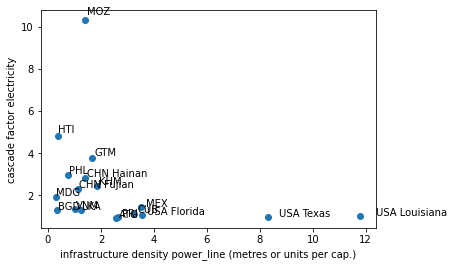

In [50]:
scatter_cascade_density(df_density_casc, 'power_line', 'electricity', annotate=True, save_path=None)

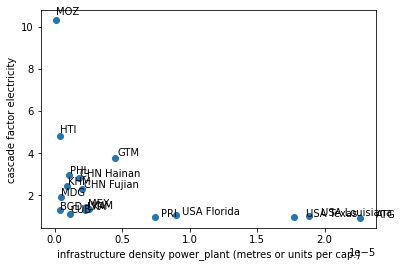

In [51]:
scatter_cascade_density(df_density_casc, 'power_plant', 'electricity', annotate=True, save_path=None)

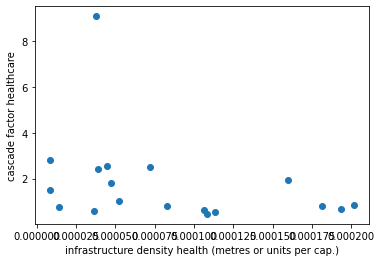

In [53]:
scatter_cascade_density(df_density_casc, 'health', 'healthcare', annotate=False, save_path=None)

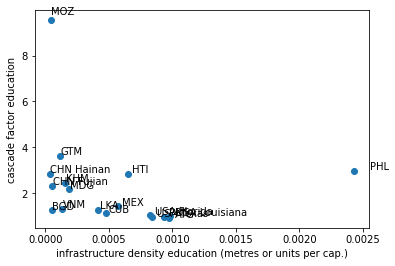

In [61]:
scatter_cascade_density(df_density_casc, 'education','education', annotate=True, save_path=None)

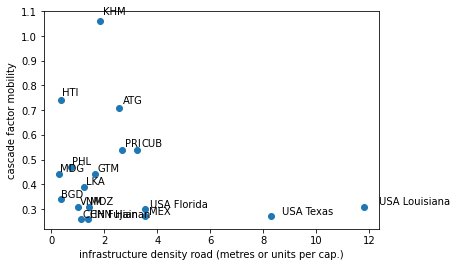

In [63]:
scatter_cascade_density(df_density_casc, 'road','mobility', annotate=True, save_path=None)